In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

#Environment that evaluates operations immediately without creating graphs
tf.enable_eager_execution()

keras = tf.keras

#import tensorflow datasets
import tensorflow_datasets as tfds



In [2]:
#divide the dataset into (train, validation, test) with 80%, 10%, 10% of the data respectively.
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [3]:
# objects contain (image, label) pairs. Where the images have variable shape and 3 channels, and the label is a scalar.
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


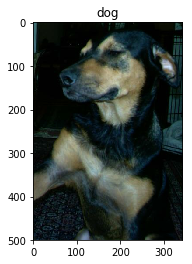

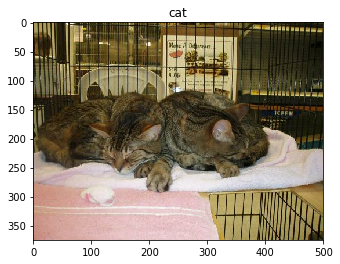

In [33]:
get_label_name = metadata.features['label'].int2str

#take function returns no of images
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))


In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

#each image having different size so we'll have to convert them to same size

def format_example(image, label):
# Cast the True and False values to 1 and 0.
  image = tf.cast(image, tf.float32)
#rescale the input channels to a range of [-1,1] Model expects values between -1 to 1 for faster convergence
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [6]:
#Apply this function to each item in the dataset using the map method:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [8]:
#create batches of size 32
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [35]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape, label_batch.shape

(TensorShape([Dimension(32), Dimension(160), Dimension(160), Dimension(3)]),
 TensorShape([Dimension(32)]))

In [37]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2 without the top layer
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
#output check
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [50]:
#Freeze weights - re-training is not required for all the layers
base_model.trainable = False

In [51]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [40]:
#Create second layer on top of base layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
#create 3rd layer on top of 2nd
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [52]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [53]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [56]:
len(model.trainable_variables)

0

In [62]:
#(print(w) for w in SPLIT_WEIGHTS)

In [20]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [21]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20==============================] - 2s 86ms/step - loss: 5.8397 - acc: 0.4828


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.84
initial accuracy: 0.48


In [23]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
590/590==============================] - 37s 62ms/step - loss: 2.2414 - acc: 0.7149 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
590/69================================================================================================================================================================================================================================================================] - 34s 58ms/step - loss: 1.1673 - acc: 0.8616 - val_loss: 0.5262 - val_acc: 0.9250
Epoch 3/10
590/69================================================================================================================================================================================================================================================================] - 34s 58ms/step - loss: 0.9652 - acc: 0.8984 - val_loss: 0.4282 - val_acc: 0.9364
Epoch 4/10
590/69=================================================================================================================================

In [27]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

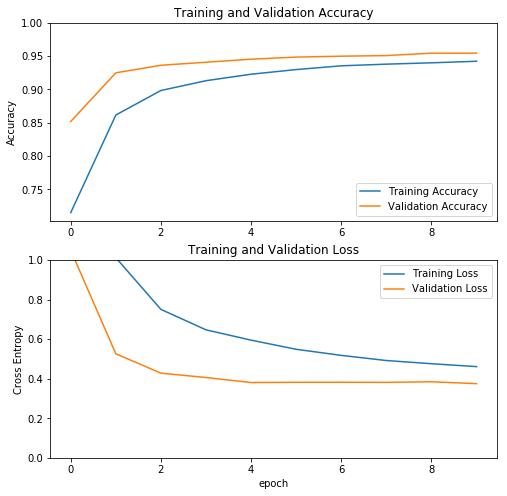

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()